#### Notebook is mainly divied into these parts:
1. Analysis of data
2. Data Preprocessing
3. Vectorization
4. Modelling
5. Parameters Optimization using gridCv
6. Discussion and Conclusion on the task!


!!!!! PS: I have tried to explain the process of coding and approach above each code block individually.

## Sweet Step :) Importing all good modules 
I have imported most common modules used for preprocessing steps like pandas, numpy , maplotlib,re,nltk,spacy (especially for german language),misc. sklearn utilities

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import spacy
!python -m spacy download de
nlp = spacy.load('de')
from sklearn import feature_extraction


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import sklearn


## Loading data using pandas

In [74]:
data=pd.read_csv('/content/sample_data.csv')

## So our data has two columns - text and label.

In [75]:
data.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


## Our data has 37295 data points

In [76]:
data.shape

(37295, 2)

## checking whether data has any nan values

- label column has some nan values which should be removed

In [77]:
data.isna().any()

text     False
label     True
dtype: bool

## dropping nan values across data

In [78]:
data.dropna(inplace=True)

## Distribution of data across different class categories

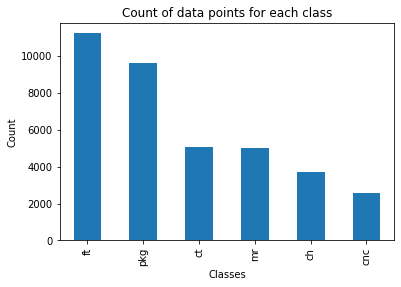

In [8]:
data['label'].value_counts().plot.bar()
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Count of data points for each class')
plt.show()

## Finding average length of every abstarct

In [9]:
data['wordcount']=data['text'].apply(lambda x: len(str(x).split(' ')))


In [10]:
data[['text','wordcount']].head()

,text,wordcount
0,zucker fabrik,2
1,Lebensmittel kommssionierung,2
2,geländer biegen,2
3,gebäudeausrüstung technische,2
4,kürbiskernöl softgels,2


In [11]:
data.wordcount.describe()

count    37295.000000
mean         2.524896
std          1.737975
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         98.000000
Name: wordcount, dtype: float64

### So average length of words per sentance is around 2 and max is 98 ,min is 1.

## Top 50 Common and Uncommon Words in corpus of text

In [43]:
#Identify common words
print('common words list ---------------------------------------')
common = pd.Series(' '.join(data['text']).split()).value_counts()[:50]
print(common)
print('<<-------------------------------------------------------------->>')
print('Uncommon words list ---------------------------------------')

uncommon=pd.Series(' '.join(data['text']).split()).value_counts()[-500:]
print(uncommon)

common words list ---------------------------------------
für              3849
von              1521
und              1457
aus              1228
cnc              1107
lebensmittel      865
mit               685
kunststoff        597
verpackung        522
bio               499
verpackungen      435
Lebensmittel      412
drehteile         333
holz              324
in                322
CNC               315
hersteller        308
fräsen            304
吉祥                300
die               298
karton            291
Lohnabfüllung     287
im                277
pulver            252
flaschen          243
Kunststoff        227
bau               224
papier            215
fräsarbeiten      194
Verpackungen      188
maschinen         186
metall            183
getränke          183
Verpackung        179
wasser            177
chemie            175
silikon           173
dosen             169
gas               168
beutel            167
gemüse            165
lohn              162
edelstahl         

## Importing Stop words for german langauge

<b>Reason for removal :</b> <br>
Stopwords are common words that are present in the text but generally do not contribute to the meaning of a sentence. They hold almost no importance for the purposes of information retrieval and natural language processing. They can safely be ignored without sacrificing the meaning of the sentence.

In [12]:
stop_words = set(stopwords.words("german"))
stemmer = SnowballStemmer("german")
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Text cleaning:
For cleaning I have used these steps:
1. remove any html tags (< /br> often found)
2. Keep only ASCII + European Chars and whitespace, no digits
3. remove single letter chars
4. convert all whitespaces (tabs etc.) to single wspace
5. removing unncessary tags spaces from the words
6. Tokenizing the words and lowering their cases
7. Stemming( Importance : Stemming is a natural language processing technique that lowers inflection in words to their root forms, hence aiding in the preprocessing of text, words, and documents for text normalization. )

In [13]:
def clean_mydata(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    
    ##Stemming
    text = [stemmer.stem(word) for word in words_tokens_lower if not word in stop_words] 
    doc = nlp(' '.join(text))
    result = ' '.join([x.lemma_ for x in doc]) 
    return result

In [14]:
data['cleaned']=data['text'].apply(lambda x:clean_mydata(x))

## Data after cleaning 

In [15]:
data.head()

,text,label,wordcount,cleaned
0,zucker fabrik,ft,2,zuck fabrik
1,Lebensmittel kommssionierung,ft,2,lebensmittel kommssionier
2,geländer biegen,mr,2,geland bieg
3,gebäudeausrüstung technische,ct,2,gebaudeausrust technisch
4,kürbiskernöl softgels,ft,2,kurbiskernol softgel


## TF-IDF

TF-IDF enables us to gives us a way to associate each word in a document with a number that represents how relevant each word is in that document.

<b>Advantages:</b>
- Easy to compute
- You have some basic metric to extract the most descriptive terms in a document
- You can easily compute the similarity between 2 documents using it

!!!!While i could have used methods like word2vec,fasttext etc. I have sticked to tf-idf because its easy to compute and those methods requires more computing time.

In [44]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data["cleaned"])

TfidfVectorizer()

## For labelling the labels , I have used label encoder and saved the classes as .npy to be later used during rest api prediction.

In [67]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y = le.fit_transform(data['label'].values)
np.save('class.npy', le.classes_,allow_pickle=True)

## Splitting the data into two parts : Training and Testing(33% of total data)

In [46]:
# Sample data 33% of data to test set
X_train, X_test, y_train, y_test = train_test_split(data['cleaned'], y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)

(24987,)
(12308,)


## Transforming each sentence to vector using tf-idf

In [47]:
# transform each sentence to numeric vector with tf-idf value as elements
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_train_vec.get_shape()

(24987, 16119)

## Classifier used:
I have used 3 classifiers:
1. LinearSVC
2. RandomForest
3. xgb (due to its popularity for kaggle competitions)

- After training and testing these models on the testing data , I am going to choose best model and do parameter optimization using grid search cv.

In [48]:
# models to test
classifiers = [
    LinearSVC(random_state=1),
    RandomForestClassifier(random_state=1),
    XGBClassifier(random_state=1)]
# get names of the objects in list (too lazy for c&p...)
names = [re.match(r"[^\(]+", name.__str__())[0] for name in classifiers]
print(f"Classifiers to test: {names}")

Classifiers to test: ['LinearSVC', 'RandomForestClassifier', 'XGBClassifier']


## Training and Testing 

In [49]:
# test all classifiers and save pred. results on test data
results = {}
for name, clf in zip(names, classifiers):
    print(f"Training classifier: {name}")
    clf.fit(X_train_vec, y_train)
    prediction = clf.predict(X_test_vec)
    report = sklearn.metrics.classification_report(y_test, prediction)
    results[name] = report

Training classifier: LinearSVC
Training classifier: RandomForestClassifier
Training classifier: XGBClassifier
CPU times: user 1min 45s, sys: 212 ms, total: 1min 46s
Wall time: 1min 51s


## Prediction results

In [50]:
# Prediction results
for k, v in results.items():
    print(f"Results for {k}:")
    print(f"{v}\n")

Results for LinearSVC:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1182
           1       0.86      0.66      0.75       858
           2       0.95      0.89      0.92      1698
           3       0.84      0.94      0.89      3720
           4       0.85      0.82      0.84      1673
           5       0.89      0.89      0.89      3148
           6       1.00      1.00      1.00        29

    accuracy                           0.88     12308
   macro avg       0.90      0.87      0.88     12308
weighted avg       0.88      0.88      0.88     12308


Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89      1182
           1       0.87      0.73      0.79       858
           2       0.96      0.87      0.91      1698
           3       0.82      0.95      0.88      3720
           4       0.86      0.81      0.84      1673
           5      

## Our LinearSVC has performed decently giving 0.88 accuracy better than random forest and xgb which gave 0.87,0.68.

<b>LinearSVC is compartively faster to train compared to other models.</b>

## Creating pipeline for the model and optimizing parameters using GridSearchCV

## Best parameters

In [52]:
print(pipe_clf.best_params_)

{'tfidf__max_df': 0.3, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}


In [ ]:
# feature creation and modelling in a single function
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("svc", LinearSVC())])

# define parameter space to test # runtime 19min
params = {
    "tfidf__ngram_range": [(1, 3)],
    "tfidf__max_df": [0.5],
    "tfidf__min_df": [5],
    "svc__C": np.arange(0.2, 1, 0.15),
}
pipe_svc_clf = GridSearchCV(pipe, params, n_jobs=-1, scoring="f1_macro")
pipe_svc_clf.fit(X_train, y_train)
pickle.dump(pipe_svc_clf, open("./pipe_svc_clf.pck", "wb"))

## Best parameters of the model

In [54]:
best_params = pipe_svc_clf.best_params_
print(best_params)

{'svc__C': 0.35, 'tfidf__max_df': 0.5, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}


In [ ]:
# run pipe with optimized parameters
pipe.set_params(**best_params).fit(X_train, y_train)
pipe_pred = pipe.predict(X_test)
report = sklearn.metrics.classification_report(y_test, pipe_pred)


In [56]:
pipe_svc_clf.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 3))),
                ('svc', LinearSVC(C=0.35))])

## saving model later for prediction

In [57]:
import joblib
joblib.dump(pipe_svc_clf.best_estimator_, 'model.pkl')

['model.pkl']

## Further Improvements in Model:
Due to time constraints I have limited myself to these models only.
Following techniques could have been used further to improve the results:
1. <b>Data Augmentation:</b> Data Samples could have been increased using 
- Replace a few words with their synonyms.
- Replace a few words with words that have similar (based on cosine similarity) word embeddings (like word2vec or GloVe) to those words.
- Replace words based on the context using powerful transformer models (BERT).

2. Using pretrained embeddings like glove etc. but challange is to find good pretrained embeddings on german langauge corpus.

3. Using chisquare test to limit the number of features in tf-idf

4. Using Techniques like:
- LSTM/GRU which are specially built for sequence data
- attention models like transformers


<b>Overall it was a very straightforward and standard task , I really enjoyed working on this task especially building restapi.</b>

I have also uploaded a video in which I showed my model working on my local server.